In [8]:
import os
import sys
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
import utils.colmap as colmap_utils
from utils.metric import camera_to_rel_deg, calculate_auc_np

import numpy as np
from matplotlib import pyplot as plt
from pytorch3d.renderer.cameras import PerspectiveCameras

In [3]:
def read_points3D_binary(path_to_model_file, selected_image_ids: dict = None):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadPoints3DBinary(const std::string& path)
        void Reconstruction::WritePoints3DBinary(const std::string& path)
    """

    with open(path_to_model_file, "rb") as fid:
        num_points = colmap_utils.read_next_bytes(fid, 8, "Q")[0]

        xyzs = []
        rgbs = []
        errors = []

        for p_id in range(num_points):
            binary_point_line_properties = colmap_utils.read_next_bytes(
                fid, num_bytes=43, format_char_sequence="QdddBBBd")
            xyz = np.array(binary_point_line_properties[1:4])
            rgb = np.array(binary_point_line_properties[4:7])
            error = np.array(binary_point_line_properties[7])
            track_length = colmap_utils.read_next_bytes(
                fid, num_bytes=8, format_char_sequence="Q")[0]
            track_elems = colmap_utils.read_next_bytes(
                fid, num_bytes=8 * track_length,
                format_char_sequence="ii" * track_length)

            # whether point belongs to selected images
            if selected_image_ids is not None:
                image_ids = np.array(tuple(map(int, track_elems[0::2])))
                point_in_selected_image_count = 0
                for image_id in image_ids:
                    if image_id in selected_image_ids:
                        point_in_selected_image_count += 1
                if point_in_selected_image_count == 0:
                    continue

            # TODO: filter points in masked area

            xyzs.append(xyz)
            rgbs.append(rgb)
            errors.append(error)
    return np.asarray(xyzs), np.asarray(rgbs), np.asarray(errors)

In [4]:
sparse_dir_vanilla = "../data/test/sparse_vanilla_25"
sparse_dir_ba = "../data/test/sparse_ba_25"
sparse_dir_gt = "../data/GauU_Scene/SMBU/sparse/0"
images_dir = "../data/GauU_Scene/SMBU/images"

cameras_vanilla = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_vanilla, "cameras.bin"))
images_vanilla = colmap_utils.read_images_binary(os.path.join(sparse_dir_vanilla, "images.bin"))
pcd_vanilla = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_vanilla, "points3D.bin"))

cameras_ba = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_ba, "cameras.bin"))
images_ba = colmap_utils.read_images_binary(os.path.join(sparse_dir_ba, "images.bin"))
pcd_ba = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_ba, "points3D.bin"))

cameras_gt = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_gt, "cameras.bin"))
images_gt = colmap_utils.read_images_binary(os.path.join(sparse_dir_gt, "images.bin"))
pcd_gt = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_gt, "points3D.bin"))

image_names = [image.name for image in list(images_vanilla.values())]
images_gt_map = {image.name: image for image in list(images_gt.values()) if image.name in image_names}
images_gt_updated = {}
for image in list(images_vanilla.values()):
    id = image.id
    images_gt_updated[id] = images_gt_map[image.name]

print(f"Number of points in vanilla: {len(pcd_vanilla)}")
print(f"Number of points in BA: {len(pcd_ba)}")
print(f"Number of points in GT: {len(pcd_gt)}")

Number of points in vanilla: 100000
Number of points in BA: 31920
Number of points in GT: 464313


Minimum Height / Image Height: -10.555984555984557 / 3636 = -0.0029031860715029033


(np.float64(-0.5), np.float64(5467.5), np.float64(3635.5), np.float64(-0.5))

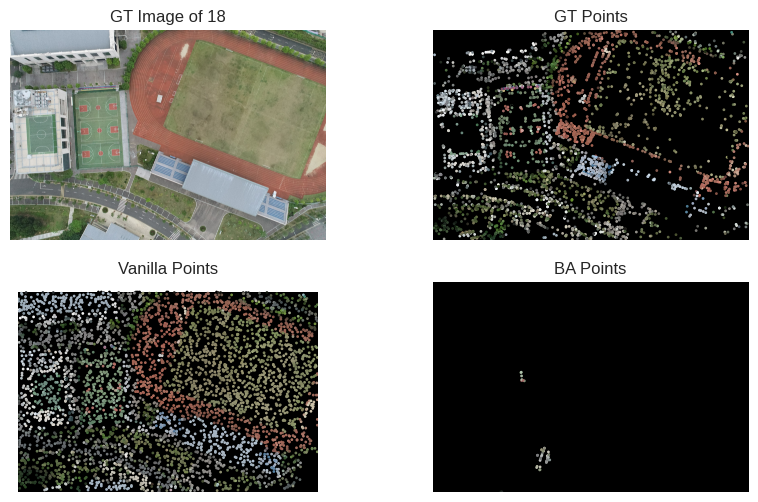

In [95]:
import random
import cv2

idx = random.choice(list(images_gt_updated.keys()))

point3D_ids_gt = images_gt_updated[idx].point3D_ids
mask_gt = point3D_ids_gt >= 0
xys_gt = images_gt_updated[idx].xys
pcd_rgb_gt = np.stack([pcd_gt[id].rgb for id in point3D_ids_gt[mask_gt]], axis=0)

point3D_ids_vanilla = images_vanilla[idx].point3D_ids
mask_vanilla = point3D_ids_vanilla >= 0
xys_vanilla = images_vanilla[idx].xys
pcd_rgb_vanilla = np.stack([pcd_vanilla[id].rgb for id in point3D_ids_vanilla[mask_vanilla]], axis=0)

point3D_ids_ba = images_ba[idx].point3D_ids
mask_ba = point3D_ids_ba >= 0
xys_ba = images_ba[idx].xys
pcd_rgb_ba = np.stack([pcd_ba[id].rgb for id in point3D_ids_ba[mask_ba]], axis=0)

image = cv2.imread(os.path.join(images_dir, images_gt_updated[idx].name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_project = np.zeros_like(image)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title(f"GT Image of {images_gt_updated[idx].id}")
plt.axis('off')

print(f"Minimum Height / Image Height: {xys_vanilla[mask_vanilla, 1].min()} / {image.shape[0]} = {xys_vanilla[mask_vanilla, 1].min() / image.shape[0]}")
# xys_vanilla[mask_vanilla, 1] -= xys_vanilla[mask_vanilla, 1].min()

plt.subplot(2, 2, 2)
plt.imshow(image_project)
plt.scatter(xys_gt[mask_gt, 0], xys_gt[mask_gt, 1], c=pcd_rgb_gt / 255.0, s=1)
plt.title("GT Points")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(image_project)
plt.scatter(xys_vanilla[mask_vanilla, 0], xys_vanilla[mask_vanilla, 1], c=pcd_rgb_vanilla / 255.0, s=1)
plt.title("Vanilla Points")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(image_project)
plt.scatter(xys_ba[mask_ba, 0], xys_ba[mask_ba, 1], c=pcd_rgb_ba / 255.0, s=1)
plt.title("BA Points")
plt.axis('off')

In [5]:
fl_vanilla = np.array([cameras_vanilla[image.camera_id].params[0:2] for image in images_vanilla.values()])
fl_ba = np.array([cameras_ba[image.camera_id].params[0:2] for image in images_ba.values()])
fl_gt = np.array([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()])

translation_vanilla = np.array([image.tvec for image in images_vanilla.values()])
translation_ba = np.array([image.tvec for image in images_ba.values()])
translation_gt = np.array([image.tvec for image in images_gt_updated.values()])

rotation_vanilla = np.array([colmap_utils.qvec2rotmat(image.qvec) for image in images_vanilla.values()])
rotation_ba = np.array([colmap_utils.qvec2rotmat(image.qvec) for image in images_ba.values()])
rotation_gt = np.array([colmap_utils.qvec2rotmat(image.qvec) for image in images_gt_updated.values()])

gt_cameras = PerspectiveCameras(
    focal_length=torch.tensor(fl_gt, device="cuda").reshape(-1, 2),
    R=torch.tensor(rotation_gt, device='cuda').reshape(-1, 3, 3),
    T=torch.tensor(translation_gt, device='cuda').reshape(-1, 3),
    device='cuda',
)

vanilla_cameras = PerspectiveCameras(
    focal_length=torch.tensor(fl_vanilla, device="cuda").reshape(-1, 2),
    R=torch.tensor(rotation_vanilla, device='cuda').reshape(-1, 3, 3),
    T=torch.tensor(translation_vanilla, device='cuda').reshape(-1, 3),
    device='cuda',
)

ba_cameras = PerspectiveCameras(
    focal_length=torch.tensor(fl_ba, device="cuda").reshape(-1, 2),
    R=torch.tensor(rotation_ba, device='cuda').reshape(-1, 3, 3),
    T=torch.tensor(translation_ba, device='cuda').reshape(-1, 3),
    device='cuda',
)

In [9]:
# compute metrics
rel_rangle_deg, rel_tangle_deg = camera_to_rel_deg(vanilla_cameras, gt_cameras, "cuda", 4)
print(f"    --  Pair Rot   Error (Deg) of Vanilla: {rel_rangle_deg.mean():10.2f}")
print(f"    --  Pair Trans Error (Deg) of Vanilla: {rel_tangle_deg.mean():10.2f}")

rError = rel_rangle_deg.cpu().numpy()
tError = rel_tangle_deg.cpu().numpy()

Auc_30 = calculate_auc_np(rError, tError, max_threshold=30)
print(f"    --  AUC at 30: {Auc_30:.4f}")

rel_rangle_deg_ba, rel_tangle_deg_ba = camera_to_rel_deg(ba_cameras, gt_cameras, "cuda", 4)
print(f"    --  Pair Rot   Error (Deg) of BA: {rel_rangle_deg_ba.mean():10.2f}")
print(f"    --  Pair Trans Error (Deg) of BA: {rel_tangle_deg_ba.mean():10.2f}")

rError_ba = rel_rangle_deg_ba.cpu().numpy()
tError_ba = rel_tangle_deg_ba.cpu().numpy()

Auc_30 = calculate_auc_np(rError_ba, tError_ba, max_threshold=30)
print(f"    --  AUC at 30: {Auc_30:.4f}")


    --  Pair Rot   Error (Deg) of Vanilla:      14.31
    --  Pair Trans Error (Deg) of Vanilla:      25.42
    --  AUC at 30: 0.4028
    --  Pair Rot   Error (Deg) of BA:      16.41
    --  Pair Trans Error (Deg) of BA:      23.69
    --  AUC at 30: 0.4650


: 